Reference : https://web.stanford.edu/class/cs224n/reports/custom/15785631.pdf

In [1]:
!pip install transformers


Looking in indexes: https://pypi.python.org/simple
Looking in indexes: https://pypi.python.org/simple
     ---------------------------------------- 0.0/373.1 kB ? eta -:--:--
     ------ -------------------------------- 61.4/373.1 kB 1.6 MB/s eta 0:00:01
     ---------------------------- --------- 276.5/373.1 kB 3.4 MB/s eta 0:00:01
     -------------------------------------- 373.1/373.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/788.5 kB ? eta -:--:--
     --------------- --------------------- 337.9/788.5 kB 10.6 MB/s eta 0:00:01
     -------------------------------------  788.5/788.5 kB 8.3 MB/s eta 0:00:01
     -------------------------------------- 788.5/788.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.12.0 requires google-auth<3,>=1.6.3, which is not installed.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-intel 2.12.0 requires wrapt<1.15,>=1.11.0, but you have wrapt 1.15.0 which is incompatible.
ray 2.0.1 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
ray 2.0.1 requires grpcio<=1.43.0,>=1.32.0; python_version < "3.10", but you have grpcio 1.51.3 which is incompatible.


In [3]:
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim import AdamW
from torchmetrics.classification import BinaryConfusionMatrix, BinaryF1Score
from argparse import ArgumentParser

from torch.optim.lr_scheduler import ExponentialLR

from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
from sklearn.metrics import f1_score

from itertools import islice
import warnings  
warnings.filterwarnings('ignore')

In [14]:

def readfiles():
    data = pd.read_csv('./Preprocess_emails.csv')

    data = data[["content", "label"]].rename(columns={"content":"SMS", "label":"target"})
    data['SMS'] = data['SMS'].astype(str)
    data['target'] = data['target'].astype(int)
    print(data)
    trainData, testData, trainLabel, testLabel = train_test_split(data["SMS"], data["target"], test_size=0.3, stratify=data["target"], random_state=42)
    
    return trainData, testData, trainLabel, testLabel





'''
def readfiles():
    path = 'spam.csv'
    
    data = pd.read_csv(path, encoding="latin-1")
    data = data[["v2", "v1"]].rename(columns={"v2":"SMS", "v1":"target"})
    data["target"] = data["target"].replace("ham", 0)
    data["target"] = data["target"].replace("spam", 1)

    trainData, testData, trainLabel, testLabel = train_test_split(data["SMS"], data["target"], test_size=0.2, stratify=data["target"], shuffle=True)
    
    return trainData, testData, trainLabel, testLabel
'''



trainData, testData, trainLabel, testLabel = readfiles()

                                                    SMS  target
0     date wed aug chri garrigu cwg date fa deepeddi...       0
1     html head titl cabl compani crack wi fi titl h...       0
2     html head titl shopper newslett alert titl hea...       0
3     martin post tasso papadopoulo greek sculptor b...       0
4     cnet download dispatch mac edit juli vol use m...       0
...                                                 ...     ...
3058  stumbl greatest way market centuri undoubtedli...       1
3059  stumbl greatest way market centuri undoubtedli...       1
3060  html head meta http equiv content languag cont...       1
3061  html bodi tr valign top td height bgcolor ffff...       1
3062  uncommon exot pleasur botan feel marvel mood s...       1

[3063 rows x 2 columns]


In [15]:
embeddings = TransformerWordEmbeddings('bert-base-uncased', layers='-1', layer_mean=False, mini_batch_size=32)

class DataEmbedding(Dataset):
    def __init__(self, data, label):

        super(DataEmbedding, self).__init__()

        self.embedding_data = self.generate_embedding(data, label)

    def __len__(self):
        return len(self.embedding_data)

    def __getitem__(self, idx):
        data_row = self.embedding_data[idx]
        return data_row[0], data_row[1]

    def generate_embedding(self, data, label):
        embedding_data_with_label = []
        for d, l in tqdm(zip(data, label)):
            sentence = Sentence(d)
            if len(sentence) > 0:
                embeddings.embed(sentence)
                #print(sentence[0].embedding.size())
                text_features = sentence[0].embedding
                sentence.clear_embeddings()

                embedding_data_with_label.append([torch.unsqueeze(text_features, 0), l])
        return embedding_data_with_label

In [16]:
batch_size = 128
train_data_set = DataEmbedding(trainData, trainLabel)
train_data_loader = DataLoader(train_data_set, batch_size=batch_size)
test_data_set = DataEmbedding(testData, testLabel)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size)



2144it [22:31,  1.59it/s]
919it [11:15,  1.36it/s]


In [17]:
class MyModule(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        
        self.clf = nn.Linear(self.hidden_size*2, 1)
    def forward(self, encoded_layers):
        bihs_lstm = torch.zeros(2, encoded_layers.size(0),encoded_layers.size(2))
        bics_lstm = torch.zeros(2, encoded_layers.size(0), encoded_layers.size(2))
        enc_hiddens, (last_hidden, last_cell) = self.bilstm(encoded_layers, (bihs_lstm, bics_lstm))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), 1)
        output_hidden = F.dropout(output_hidden,0.2)

        output = self.clf(output_hidden)
        return F.sigmoid(torch.squeeze(output))

model = MyModule(768)

train:
-----------------------------------------------------------
| end of epoch 1 | loss: 0.0007726032563903787
-----------------------------------------------------------
accuracy: 0.9995335820895522
precision: 1.0
recall: 0.999462654486835
-----------------------------------------------------------
| end of epoch 2 | loss: 0.0021934292677435545
-----------------------------------------------------------
accuracy: 0.9995335820895522
precision: 0.9994629430719656
recall: 1.0
-----------------------------------------------------------
| end of epoch 3 | loss: 0.0004377578370889858
-----------------------------------------------------------
accuracy: 1.0
precision: 1.0
recall: 1.0
-----------------------------------------------------------
| end of epoch 4 | loss: 0.0001440061819534201
-----------------------------------------------------------
accuracy: 1.0
precision: 1.0
recall: 1.0
-----------------------------------------------------------
| end of epoch 5 | loss: 0.000583287097202

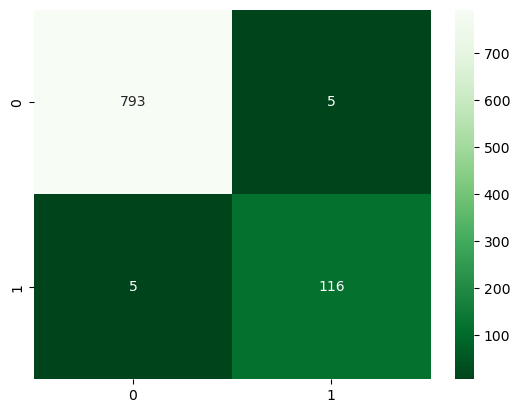

In [22]:

import seaborn as sn

epoch = 10

metric = BinaryConfusionMatrix()
fmetric = BinaryF1Score()

def train_and_eval(model, dataloader, epoch, optimizer=None, train=False):

    criterion = torch.nn.BCELoss()
    assert not train or optimizer != None
    if train:
        result = []
        print("train:")
        model.train()
        for e in range(1, epoch + 1):
            total_losses = []
            prediction = None
            true_label = None
            for context,target in dataloader:
                optimizer.zero_grad()
                pred = model(context)
                
                if prediction is None:
                    prediction = pred
                    true_label = target
                else:
                    prediction = torch.cat((prediction, pred), 0)
                    true_label = torch.cat((true_label, target), 0)
                target = target.type(torch.FloatTensor)
                loss = criterion(pred, target)
                loss.backward()
                optimizer.step()
                total_losses.append(loss.item())
            metri = metric(prediction, true_label).numpy()
            print('-' * 59)
            print('| end of epoch {} | loss: {}'.format(e, np.mean(total_losses)))
            print('-' * 59)
            accuracy = (metri[0][0] + metri[1][1])/(metri[0][0] + metri[0][1] + metri[1][0] + metri[1][1])
            precision = metri[0][0]/(metri[0][0] + metri[1][0])
            recall = metri[0][0]/(metri[0][0] + metri[0][1])
            print("accuracy: " + str(accuracy))
            print("precision: " + str(precision))
            print("recall: " + str(recall))
            result.append(metri)
    else:
        print("test:")
        model.eval()
        prediction = None
        for context,target in dataloader:
            optimizer.zero_grad()
            pred = model(context)
                
            if prediction is None:
                prediction = pred
                true_label = target
            else:
                prediction = torch.cat((prediction, pred), 0)
                true_label = torch.cat((true_label, target), 0)
            target = target.type(torch.FloatTensor)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
        metri = metric(prediction, true_label).numpy()

        accuracy = (metri[0][0] + metri[1][1])/(metri[0][0] + metri[0][1] + metri[1][0] + metri[1][1])
        precision = metri[0][0]/(metri[0][0] + metri[1][0])
        recall = metri[0][0]/(metri[0][0] + metri[0][1])
        fscore = fmetric(prediction, true_label)
        print("test_accuracy: " + str(accuracy))
        print("test_precision: " + str(precision))
        print("test_recall: " + str(recall))
        print("f1 score: " + str(fscore))
        result = metri
    return result
    

            
optimizer = AdamW(model.parameters(), lr=0.001)

train_result = train_and_eval(model, train_data_loader, epoch, optimizer=optimizer, train=True)
test_result = train_and_eval(model, test_data_loader, epoch, optimizer=optimizer, train=False)
ax = sn.heatmap(test_result, annot=True, fmt='.20g',cmap='Greens_r')